#### Load Libraries

In [44]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import scipy

rng = np.random.RandomState(123)
tf.random.set_seed(42)

#### Utility Functions

In [45]:

def resort_data(X_test, *args):
    """
    Function to resort data, such that they are in ascending order wrt X_test. Useful for plotting curves.

    Args:
        X_test (array)

    Returns:
        X_test reordered
    """


    X_test, *args = zip(*sorted(zip(X_test, *args)))

    X_test = np.array(X_test)
    
    args = [np.array(arg) for arg in args]

    return X_test, *args

In [46]:
## 
def load_1D_dataset(N_total=200, test_set_proportion=0.2):
    """
    Function to load a customisable toy 1D regression dataset

    Args:
        N_total (int, optional): Total number of data points. Defaults to 200.
        test_set_proportion (float, optional): Proportion of test point to all data points. Defaults to 0.2.
    """
    
    def func(x):
        return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

    N_tot = N_total  # Number of total input points (training and test)

    X = rng.rand(N_tot, 1) * 2 - 1  # X values
    Y = func(X) + 0.2 * rng.randn(N_tot, 1)  # Noisy Y values

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=test_set_proportion,
        random_state=88,
        shuffle=True
        )

    X_test, Y_test = resort_data(X_test, Y_test)

    return  X_train, X_test, Y_train, Y_test




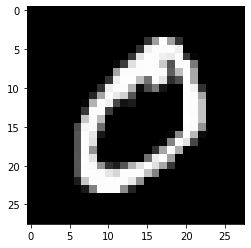

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [47]:

def load_dataset(dataset="1D"):
    """
    Dataset loading utility function.

    Args:
        dataset (str, optional): the string of the dataset to be loaded. Defaults to "1D".

    Returns:
        Training and test outputs. One hot encoding for classification datasets.
    """
    if dataset=="1D":
        x_train, x_test, y_train, y_test = load_1D_dataset()
        return x_train, x_test, y_train, y_test
    elif dataset=="mnist":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        assert x_train.shape == (60000, 28, 28)
        assert x_test.shape == (10000, 28, 28)
        assert y_train.shape == (60000,)
        assert y_test.shape == (10000,)

        # preprocessing
        x_train = x_train.reshape(60000, 784)/255
        x_test = x_test.reshape(10000, 784)/255
        
    else:
        if dataset=="diabetes":
            data = load_diabetes()
        if dataset=="breast":
            data = load_breast_cancer()
        if dataset=="iris":
            data = load_iris()
        if dataset=="digits":
            data = load_digits()


        y = data["target"]
        #y = np.array([float(y_one) for y_one in y])
        X = data["data"]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


        
        # print(C)


    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    N = len(y_train)

    if dataset== "breast" or "iris" or "digits" or "mnist":

        C = len(unique_labels(y_train))
        y_hot = np.zeros((N, C))
        
        y_hot = OneHotEncoder(handle_unknown='ignore').fit_transform(y_train).toarray()

        # print("poo")

        #y_hot = y_hot.reshape(-1, 1)

        return x_train, x_test, y_hot, y_test

    else:

        D = len(x_train[0])

        return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = load_dataset(dataset="mnist")

plt.imshow(x_train[1].reshape(28, 28), cmap='gray')
plt.show()

print(type(y_train[1]))
print(type(x_train[1]))
print(type(x_train[1,1]))





In [48]:
def LPD_fn(Y_predict_mu, Y_predict_var, Y_test):
    """
        Loss function - negative log validation density loss.

    Args:
        - X_train: Input values for training dataset
        - Y_train: Output values for training dataset
        - X_test: Input values for test dataset

    Returns:
        - Y_predict_mu: Predicted output values for inputs X_test
        - Y_predict_var: The variances for Y_predict_mu

    
    """

    term_1 = np.log(Y_predict_var)
    term_2 = ((Y_predict_mu - Y_test)**2)/(Y_predict_var)
    term_3 = np.log(2*np.pi)
    return np.sum(-0.5*(term_1+term_2+term_3))


# ! this function doesnt make sense yet
def MSE(Y_predict_mu, Y_predict_var, Y_test):
    return np.mean((Y_predict_mu - Y_test)**2)

#### Experiments

##### SGPR

Initialising the model

In [114]:

#* Number of inducing points
M = 1000

#* Random initialisation of inducing points
Z_SGPR = x_train[:M, :].copy()

#* Number of classes for a classification dataset
C = len(unique_labels(y_train))


#* ARD SE kernel
kernel_ard = gpflow.kernels.SquaredExponential(lengthscales=np.ones(len(x_train[0])))
#* SE kernel
kernel = gpflow.kernels.SquaredExponential()


#* Initialise the model
m = gpflow.models.SGPR(
    data=(x_train, y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel,
    # num_latent_gps=C  #-- apparently this is not necessary for the model (see the source code if you want to see why)
    )
    

#* Set trainable parameters
gpflow.set_trainable(m.inducing_variable, False)

#* Pick value for jitter
jitter = 1e-3
gpflow.config.set_default_jitter(jitter)


#* Initialise hyperparams
var_y = 1
var_f = var_y
kappa = 1
var_n = var_f / kappa

m.likelihood.variance.assign(var_n)
m.kernel.variance.assign(var_y)
m.kernel.lengthscales.assign(10)



m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(1000, 784)",float64,"[[0., 0., 0...."


Training the model by optimising the ELBO

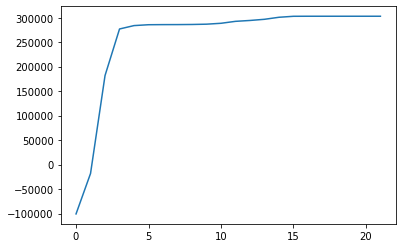

In [115]:
# #-- Optimisation

#* Optimiser object
opt = gpflow.optimizers.Scipy()

#* List for ELBO values during 
logs = []


def log_opt(x):
    """
    Utility function to log the elbo score for each iteration during optimisaiton.

    Args:
        x
    """
    logs.append(float(m.elbo()))
    # logs.append(float(m.log_marginal_likelihood()))


#* Optimise
log = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=300),
    callback=log_opt,
    )

# print(logs)
plt.plot(logs)
plt.show()

In [116]:
# #-- Show the new model parameters
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.009226140657825859
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6.117649089461928
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.018631413001187595
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(1000, 784)",float64,"[[0., 0., 0...."


In [117]:
print(m.elbo())

tf.Tensor(302908.3678140197, shape=(), dtype=float64)


Making predictions

In [118]:
y_pred, var = m.predict_y(x_test)

print(y_pred[:4])

print(np.shape(x_test))
print(np.shape(y_test))
print(np.shape(y_pred))
print(np.shape(x_train))
print(np.shape(y_train))


tf.Tensor(
[[-0.02180869 -0.01871783 -0.00572968  0.00664324 -0.04052388  0.01313393
   0.00787949  1.06132869  0.05770783 -0.05171545]
 [ 0.06165025 -0.09523178  0.68783787  0.19215618 -0.04555698 -0.0218745
   0.21037257  0.0064164  -0.02666623  0.00434883]
 [ 0.00389339  0.96462501  0.00556539 -0.02839849  0.00391607  0.04538193
   0.01367806 -0.00814623 -0.00747944  0.01121672]
 [ 0.93504778  0.01380227 -0.04284333  0.05176945  0.01351825 -0.00891388
   0.05962564  0.0494236   0.00904066 -0.08610958]], shape=(4, 10), dtype=float64)
(10000, 784)
(10000, 1)
(10000, 10)
(60000, 784)
(60000, 10)


In [119]:
y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
# print(MSE(y_pred, var, y_test))
# print(LPD_fn(y_pred, var, y_test))

# //plt.scatter(x_test, y_pred)
# //plt.scatter(x_train, y_train, color='black')
# //plt.show()

print(accuracy_score(y_test, y_pred_labels))

0.9525


In [120]:

print(y_pred_labels[:20].reshape(1,-1))
print(y_test[:20].reshape(1,-1))

[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]]
[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]]


##### Hyperparameter search

In [25]:

#* Initialise the model
m_search = gpflow.models.SGPR(
    data=(x_train, y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel,
    )

m_search

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.10000000000000002
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(50, 784)",float64,"[[0., 0., 0...."


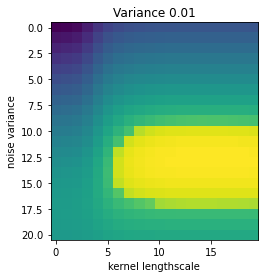

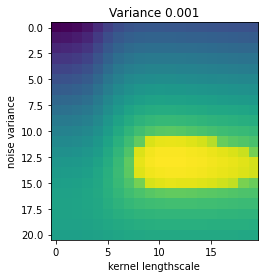

In [175]:

var_range = [1e-2, 1e-3];

noise_range = np.geomspace(0.005, 0.16, 21)

len_range = np.linspace(1, 10, 20)

elbos = []
for var_y in var_range:

    elbo_y = []
    m_search.kernel.variance.assign(var_y)
    
    for var_n in noise_range:
        m_search.likelihood.variance.assign(var_n)
        elbo_n = []
        for lengthscale in len_range:
            m_search.kernel.lengthscales.assign(lengthscale)
            elbo_l = m_search.elbo()
            elbo_n.append(elbo_l)
        elbo_y.append(elbo_n)
    elbos.append(elbo_y)
    plt.imshow(np.cbrt(elbo_y))
    plt.xlabel("kernel lengthscale")
    plt.title("Variance {}".format(var_y))
    plt.ylabel("noise variance")
    plt.show()

In [29]:
print(elbos)

[[[<tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013508705>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013449048>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013453133>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.01345414>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013451904>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013452311>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013452652>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013452495>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013452566>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013452586>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.013452569>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692094.01344574>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692093.739413822>, <tf.Tensor: shape=(), dtype=float64, numpy=-6692044.050914635>, <tf.Tensor: shape=(), dtype=float64, numpy=-6684722.908541184>, <tf.Tensor: shape=(), dtype=float64, nu

In [171]:
im = plt.imshow(np.cbrt(elbos[0]), interpolation="spline16")
ax = plt.gca();

# # Major ticks
ax.set_xticks(np.linspace(0, 20, 10))
ax.set_yticks(np.linspace(0, 21, 6))

# Labels for major ticks


ax.set_yticklabels([0.005, 0.01, 0.02, 0.04, 0.08, 0,16])
ax.set_xticklabels(np.linspace(0,10,10))
# plt.yscale('log')
# plt.xscale('log')
# ax.set_xticklabels([str(element) for element in np.round(len_range, decimals=3)])
# ax.set_yticklabels([str(element) for element in np.round(noise_range, decimals=3)], minor=True)


# plt.set_ticks(ticks=[str(element) for element in np.round(len_range, decimals=3)])
plt.xlabel("kernel lengthscale")
plt.title("Variance {}".format(var_y))
plt.ylabel("noise variance")
plt.show()

IndexError: list index out of range

In [170]:
print(len_range)
print(noise_range)

[ 1.          1.47368421  1.94736842  2.42105263  2.89473684  3.36842105
  3.84210526  4.31578947  4.78947368  5.26315789  5.73684211  6.21052632
  6.68421053  7.15789474  7.63157895  8.10526316  8.57894737  9.05263158
  9.52631579 10.        ]
[0.005      0.00594604 0.00707107 0.00840896 0.01       0.01189207
 0.01414214 0.01681793 0.02       0.02378414 0.02828427 0.03363586
 0.04       0.04756828 0.05656854 0.06727171 0.08       0.09513657
 0.11313708 0.13454343 0.16      ]


In [147]:
print([str(element) for element in np.round(len_range, decimals=3)])


['0.001', '0.002', '0.003', '0.004', '0.007', '0.011', '0.018', '0.03', '0.048', '0.078', '0.127', '0.207', '0.336', '0.546', '0.886', '1.438', '2.336', '3.793', '6.158', '10.0']


In [174]:
print(np.linspace(0, 20, 2))
print(np.linspace(0, 20, 6))

[ 0. 20.]
[ 0.  4.  8. 12. 16. 20.]
